In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from particles import kalman
# set options

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Exercise 1 - State space modeling for the annual flow of river Nile

## Question 1

Read the river Nile dataset using the read_csv function from the pandas package.


In [2]:
df = pd.read_csv('nile.csv')

df['year'] = np.arange(1871, 1971)

df.head()

,flow,year
0,1120,1871
1,1160,1872
2,963,1873
3,1210,1874
4,1160,1875


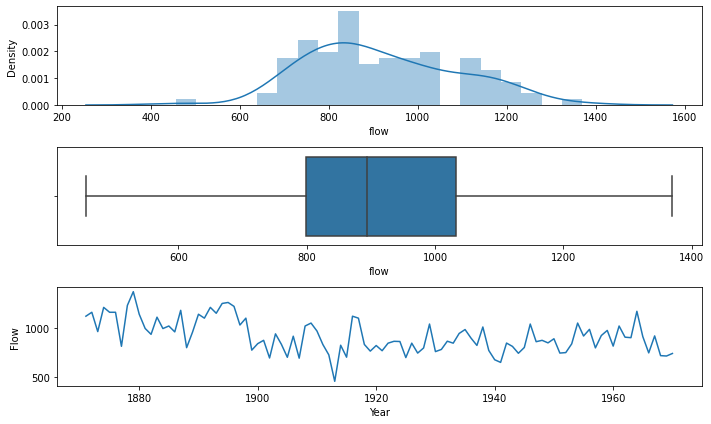

In [3]:
# plot distribution of Nile river flow, boxplot and lineplot of flow over time

fig, ax = plt.subplots(3, 1, figsize=(10, 6))

sns.distplot(df['flow'], bins=20, ax=ax[0])
plt.xlabel('Flow')
plt.ylabel('Frequency')

sns.boxplot(df['flow'], ax=ax[1])
plt.xlabel('Flow')

sns.lineplot(x='year', y='flow', data=df, ax=ax[2])
plt.xlabel('Year')
plt.ylabel('Flow')

plt.tight_layout()
plt.show()


## Question 2

We will use the first 80 measurements from 1871 to 1950 as our training dataset and the last
20 measurements from 1951 to 1970 as our testing dataset. Implement this split.

In [4]:
# train test split
## train is first 80 measurements and test is last 20 measurements, only flow column is used for training and testing

df_train = df.iloc[:80, :]

df_test = df.iloc[80:, :]
# Print shapes of train and test dataframes

print(f'Train shape: {df_train.shape}, Test shape: {df_test.shape}')


Train shape: (80, 2), Test shape: (20, 2)


In [5]:
df_train.head()

,flow,year
0,1120,1871
1,1160,1872
2,963,1873
3,1210,1874
4,1160,1875


## Question 3

Plot the time series and observe the apparent changepoint near 1898. Speculate why this might be the case.

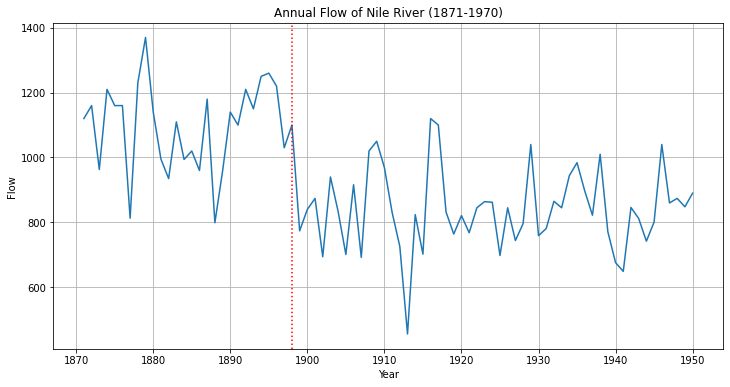

In [8]:
# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(df_train['year'], df_train['flow']) #plotting the flow of the train set to have a better look at the 1898 inflection point
# plt.plot(df['year'], df['flow']) remove comment of this line and comment above line to see the whole time series
plt.axvline(x=1898, color='red', linestyle='dotted')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Annual Flow of Nile River (1871-1970)')
plt.grid(True)
plt.show()

One possible explanation of this flow decrease is natural climate that could have cause a flooding. Also, other possible impacts could be construction that could alter the river flow such as dams, irrigations and other exploitation of the river.

## Question 4

We will model the annual flow Xt and its measurement Yt
in year t+1871, for t = 0, 1, . . . , 99,
using the following univariate linear Gaussian state space model
X0 ∼ N(1120, 1450),
Xt = Xt−1 + Ut, Ut ∼ N(0, σ^2_X), (1)
Yt = Xt + Vt, Vt ∼ N(0, σ^2_Y).
Using the kalman module from the particles package, write a function that constructs the
state space model (1) for any choice of parameters θ = (σ^2_X, σ^2_Y). This function should take σ^2_X and σ^2_Y as arguments and output a MVLinearGauss object.

In [53]:
def construct_ssm(sigma_X, sigma_Y):
    # Initial distribution
    mu0 = np.array([1120])
    cov0 = np.array([[1450]])  #  2-dimensional array

    # State transition matrix
    F = np.array([[1]])

    # Transition covariance matrix
    Sigma_X = np.array([[sigma_X]])  # 2-dimensional array

    # Observation transition matrix
    G = np.array([[1]])

    # Observation covariance matrix
    Sigma_Y = np.array([[sigma_Y]])  #2-dimensional array

    # Create the state space model
    ssm = kalman.MVLinearGauss(F=F, G=G, covX=Sigma_X, covY=Sigma_Y, mu0=mu0, cov0=cov0)

    return ssm

# True data generating state space model
ssm = construct_ssm(sigma_X=1, sigma_Y=1)
T = len(df_train)
states, obs = ssm.simulate(T = T)  # Simulate data

In [54]:
print(type(states))
print(len(states))

print(type(obs))
print(len(obs))

<class 'list'>
80
<class 'list'>
80


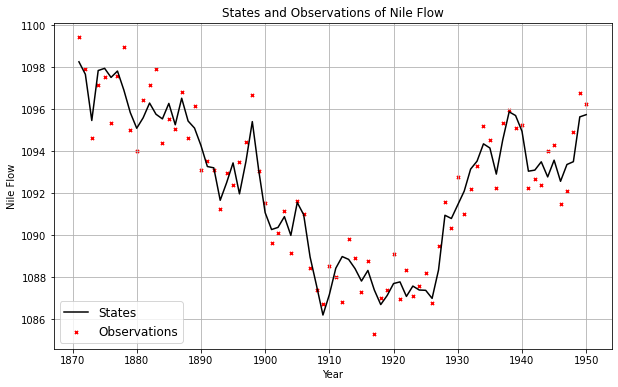

In [55]:
# Extracting the values from true states and observations
X = [x[0, 0] for x in states]
Y = [y[0, 0] for y in obs]

# Plotting the true states and observations
plt.figure(figsize=(10, 6))
plt.plot(df_train['year'], X, color='black', label='States')
plt.scatter(df_train['year'], Y, label='Observations', marker='x', color='red', s=10)
plt.xlabel('Year')
plt.ylabel('Nile Flow')
plt.title('States and Observations of Nile Flow')
plt.legend(fontsize=12, loc='lower left')
plt.grid(True)
plt.show()

## Question 5

Let y_0, y_1, . . . , y_79 denote the 80 measurements from 1871 to 1950 in our training dataset.
Using the kalman module from the particles package, write a function that evaluates the log-likelihood log p(y0, y1, . . . , y79|θ) for any θ ∈ (0, ∞)^2 with the Kalman filter. This function should take as argument theta a vector of size 2 and output a numerical value.

In [56]:
from scipy.optimize import minimize

y_train = np.array(df_train['flow'])

def loglikelihood(theta):
    # Get parameters
    sigma_X = theta[0]
    sigma_Y = theta[1]

    # Construct state space model
    ssm = construct_ssm(sigma_X, sigma_Y)

    # Run Kalman filtering to evaluate the log-likelihood
    kalman_filter = kalman.Kalman(ssm=ssm, data=y_train)
    kalman_filter.filter()

    # Return log-likelihood using sum
    return np.sum(kalman_filter.logpyt)

## Question 6

Compute the maximum likelihood estimator
θ = arg max log p(y0, y1, . . . , y79|θ) 
using the minimize function from the SciPy optimize subpackage. Initialize the optimization routine at θ = (σ^2X, σ2^Y) = (1450, 15000) and use the Nelder–Mead algorithm by specifying the method parameter.

In [57]:
from scipy.optimize import minimize
def neg_loglikelihood(theta):
    return -loglikelihood(theta)

# Initialize optimization routine
initial_theta = [1400, 16000]
result = minimize(neg_loglikelihood, initial_theta, method='Nelder-Mead', options= {'disp': True, 'maxiter': 1000})

# Extract maximum likelihood estimator
estimated_theta = result.x

# Print the estimated theta
print("Estimated Theta:", estimated_theta)

Optimization terminated successfully.
         Current function value: 512.279738
         Iterations: 49
         Function evaluations: 104
Estimated Theta: [ 1438.04449004 16003.77103282]


## Question 7

Using the kalman module from the particles package, perform Kalman filtering and Kalman smoothing on the state space model (1) with the maximum likelihood estimator θb.

In [58]:
# Construct state space model with estimated theta
sigma_X = estimated_theta[0]
sigma_Y = estimated_theta[1]
ssm = construct_ssm(sigma_X, sigma_Y)

# Run Kalman filtering
kalman_filter = kalman.Kalman(ssm=ssm, data=y_train)
kalman_filter.filter()
kalman_filter.smoother()

## Question 8

Plot the filtering mean E[Xt|θ, y b 0, y1, . . . , yt ], the smoothing mean E[Xt |θ, y b 0, y1, . . . , y79] and the measurement yt for t = 0, 1, . . . , 79. Comment on the differences between the filtering and smoothing means. Explain why the changepoint near 1898 is also reflected in these
means.

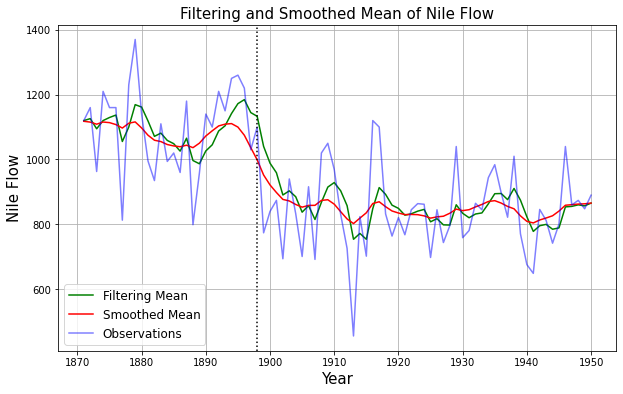

In [59]:
# PLot the filtering mean and smoothed mean for y_t = 0,1,...,T

# Extract the filtering mean and smoothed mean

filtering_means = [filtering.mean[0] for filtering in kalman_filter.filt]
filtering_covs = [filtering.cov[0] for filtering in kalman_filter.filt]

smoothed_means = [smoothing.mean[0] for smoothing in kalman_filter.smth]
smoothed_covs = [smoothing.cov[0] for smoothing in kalman_filter.smth]

# Plot the filtering mean and smoothed mean

plt.figure(figsize=(10, 6))

plt.plot(df_train['year'], filtering_means, color='green', label='Filtering Mean')
plt.plot(df_train['year'], smoothed_means, color='red', label='Smoothed Mean')
plt.plot(df_train['year'], y_train, color='blue', label='Observations', alpha=0.5)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Nile Flow', fontsize=15)

plt.title('Filtering and Smoothed Mean of Nile Flow', fontsize=15)
plt.legend(fontsize=12, loc='lower left')

plt.axvline(x=1898, color='black', linestyle='dotted')

plt.grid(True)

plt.show()

## Question 9

Compare the filtering variance Var[Xt|θ, y b 0, y1, . . . , yt] and the smoothing variance Var[Xt|θ, y b 0, y1, . . . , y79] for t = 0, 1, . . . , 79. Explain these differences.

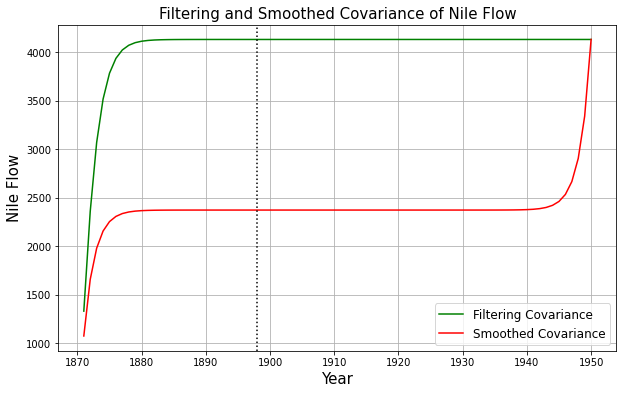

In [60]:
figure = plt.figure(figsize=(10, 6))

plt.plot(df_train['year'], filtering_covs, color='green', label='Filtering Covariance')
plt.plot(df_train['year'], smoothed_covs, color='red', label='Smoothed Covariance')

plt.xlabel('Year', fontsize=15)
plt.ylabel('Nile Flow', fontsize=15)

plt.title('Filtering and Smoothed Covariance of Nile Flow', fontsize=15)

plt.legend(fontsize=12, loc='lower right')

plt.axvline(x=1898, color='black', linestyle='dotted')

plt.grid(True)

plt.show()


## Question 10

Using the state space model (1) with the maximum likelihood estimator θb, compute the predictive mean E[Yt |θ, y b 0, y1, . . . , y79] and the predictive variance Var[Yt |θ, y b 0, y1, . . . , y79], for t = 80, . . . , 99, of the 20 measurements from 1951 to 1970.

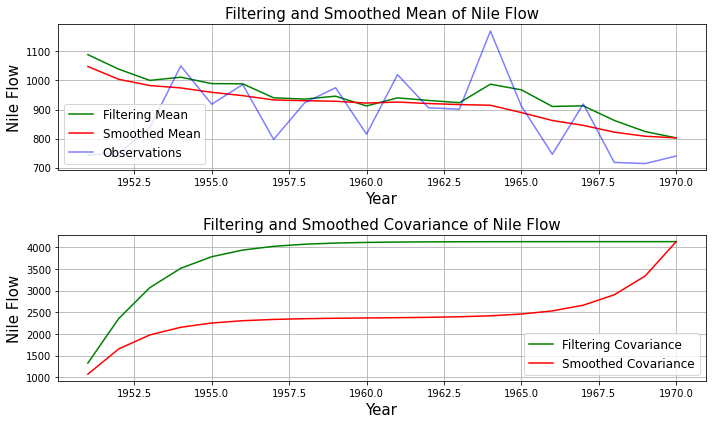

In [61]:
y_test = np.array(df_test['flow'])

T = len(y_test)

# Run Kalman filtering
kalman_filter = kalman.Kalman(ssm=ssm, data=y_test)

kalman_filter.filter()
kalman_filter.smoother()

# Extract the filtering mean and smoothed mean

filtering_means_pred = [filtering.mean[0] for filtering in kalman_filter.filt]
filtering_covs_pred = [filtering.cov[0] for filtering in kalman_filter.filt]

smoothed_means_pred = [smoothing.mean[0] for smoothing in kalman_filter.smth]
smoothed_covs_pred = [smoothing.cov[0] for smoothing in kalman_filter.smth]

# Plot the filtering mean and smoothed mean

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(df_test['year'], filtering_means_pred, color='green', label='Filtering Mean')
ax[0].plot(df_test['year'], smoothed_means_pred, color='red', label='Smoothed Mean')
ax[0].plot(df_test['year'], y_test, color='blue', label='Observations', alpha=0.5)

ax[0].set_xlabel('Year', fontsize=15)
ax[0].set_ylabel('Nile Flow', fontsize=15)

ax[0].set_title('Filtering and Smoothed Mean of Nile Flow', fontsize=15)

ax[0].legend(fontsize=12, loc='lower left')

ax[0].grid(True)

ax[1].plot(df_test['year'], filtering_covs_pred, color='green', label='Filtering Covariance')
ax[1].plot(df_test['year'], smoothed_covs_pred, color='red', label='Smoothed Covariance')

ax[1].set_xlabel('Year', fontsize=15)
ax[1].set_ylabel('Nile Flow', fontsize=15)

ax[1].set_title('Filtering and Smoothed Covariance of Nile Flow', fontsize=15)

ax[1].legend(fontsize=12, loc='lower right')

ax[1].grid(True)

plt.tight_layout()

plt.show()

## Question 11

Using the predictive means and variances, compare the predictive distributions with the 20 measurements from 1951 to 1970 in our testing dataset.

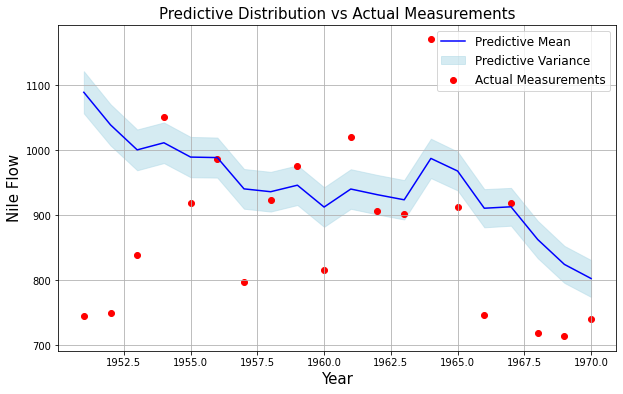

In [62]:
# Plot the predictive mean and variance along with the actual measurements
plt.figure(figsize=(10, 6))
plt.plot(range(1951, 1971), filtering_means_pred, color='blue', label='Predictive Mean')
plt.fill_between(range(1951, 1971), filtering_means_pred - np.sqrt(smoothed_means_pred), filtering_means_pred + np.sqrt(smoothed_means_pred), color='lightblue', alpha=0.5, label='Predictive Variance')
plt.scatter(df_test['year'], y_test, color='red', label='Actual Measurements')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Nile Flow', fontsize=15)
plt.title('Predictive Distribution vs Actual Measurements', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# **NEEED TO CHANGE TITLE UNDERNEATH**

# Exercise 2 - YouPorn 